![alt text](imgs/SFT.gif)

# Supervised Fine-Tuning (SFT) with Parameter Efficient Fine Tuning(PEFT LoRA) of Amazon Nova 2.0 using Amazon SageMaker Training Job

You can customize Amazon Nova models through base recipes using Amazon SageMaker training jobs. These recipes support Supervised Fine-Tuning (SFT)with both Full-Rank and Low-Rank Adaptation (LoRA) options, and reinforcement fine tuning (RFT).


This notebook demonstrates Supervised Fine-Tuning (SFT) with Parameter-Efficient Fine-Tuning (PEFT) of Amazon Nova using Amazon SageMaker Training Job. SFT is a technique that allows fine-tuning language models on specific tasks using labeled examples, while PEFT enables efficient fine-tuning by updating only a small subset of the model's parameters.


> _**Note:** This notebook demonstrates fine-tuning using Nova Lite, but the same techniques can be applied to Nova Pro or Nova Micro models with appropriate adjustments to the configuration._


### Low-rank adapter fine tuning


The most effective and cost-efficient method to enhance the base model performance is through the utilization of Low Rank Adapter (LoRA) fine-tuning. The underlying principle of LoRA is that only a small number of additional weights requires updating to adapt it to new tasks or domains. LoRA efficiently fine-tunes large language models by introducing low-rank trainable weight matrices into specific model layers, reducing the number of trainable parameters while maintaining model quality. A LoRA adapter augments the base foundation model by incorporating lightweight adapter layers that modify the model’s weights during inference, while keeping the original model parameters frozen. This approach is also considered one of the most cost-effective fine-tuning techniques. For more information, see Fine-tune models with adapter inference components

In what cases is Low-rank Adapter Fine tuning recommended?

* Developers are recommended to generally start with Low-rank Adapter Fine tuning due to its fast training procedure.
* It is recommended to use Low-rank Adapter (LoRA) fine-tuning in cases where the base model performance is already satisfactory, and the goal is to enhance the model's capabilities across multiple related tasks, such as text summarization and language translation. LoRA's regularization properties help prevent over-fitting and mitigate the "forgetting" of the source domain, ensuring the model remains versatile and adaptable to various applications.
* Consider using LoRA for instruction fine-tuning (IFT) scenarios with relatively small datasets. LoRA performs better with smaller, task-specific datasets than broader larger datasets.
* It is recommended to leverage Low-rank Adapter (LoRA) fine-tuning on Amazon SageMaker AI when the developer has a larger labeled dataset that exceeds the Bedrock Customization Data Limits.
* Additionally, LoRA on SageMaker AI is recommended when the developer has already achieved promising results through Bedrock Customization, and seeks to further optimize hyper-parameters.


## Model fine-tuning

We now define the PyTorch estimator to run the supervised fine-tuning on a tool-calling dataset for our Amazon Nova model

This section sets up and runs the fine-tuning job using SageMaker. It uses Supervised Fine-Tuning (SFT) with Parameter-Efficient Fine-Tuning (PEFT) to efficiently train the model.


#### Prerequisites

This section sets up the necessary AWS credentials and SageMaker session to run the notebook. You'll need proper IAM permissions to use SageMaker.


If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.

The code initializes a SageMaker session, sets up the IAM role, and configures the S3 bucket for storing training data and model artifacts.


In [ ]:
import sagemaker
import boto3
import os

sess = sagemaker.Session()
sagemaker_session_bucket = None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
bucket_name = sess.default_bucket()
default_prefix = sess.default_bucket_prefix

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

#### Instance Type and Count

P5 instances are optimized for deep learning workloads, providing high-performance GPUs.


In [48]:
instance_type = "ml.p5.48xlarge"
instance_count = 4

instance_type

'ml.p5.48xlarge'

#### Image URI

This specifies the pre-built container for SFT fine-tuning for Nova Lite 2.0.

In [49]:
image_uri = f"708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-V2-latest"

image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-V2-latest'

#### Configuring the Model and Recipe

This specifies which model to fine-tune and the recipe to use. The recipe includes "lora" indicating parameter-efficient fine-tuning, and "sft" indicating supervised fine-tuning.


In [ ]:
model_id = "nova-lite-2/prod"
recipe = "fine-tuning/nova/nova_2_0/nova_lite/SFT/nova_lite_2_0_p5_gpu_lora_sft.yaml" # https://github.com/aws/sagemaker-hyperpod-recipes/blob/main/recipes_collection/recipes/fine-tuning/nova/nova_2_0/nova_lite/SFT/nova_lite_2_0_p5_gpu_lora_sft.yaml

In [51]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"train-{model_id.split('/')[0].replace('.', '-')}-peft-sft"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"

recipe_overrides = {
    "run": {
        "replicas": instance_count,  # Required
    },
}

estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    recipe_overrides=recipe_overrides,
    max_run=432000,
    sagemaker_session=sess,
    image_uri=image_uri
)

INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.


#### Configuring the Data Channels

Supply uploaded S3 data for training from previous notebook

In [ ]:
%store -r train_dataset_s3_path_sft
%store -r test_dataset_s3_path_sft
%store -r val_dataset_s3_path_sft
%store -r train_dataset_s3_path_rft
%store -r test_dataset_s3_path_rft
%store -r val_dataset_s3_path_rftf


In [ ]:
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=train_dataset_s3_path_sft,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

val_input = TrainingInput(
    s3_data=val_dataset_s3_path_sft,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

### Starting the Training Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [ ]:
# starting the train job with our uploaded datasets as input
estimator.fit(inputs={"train": train_input, "validation": val_input}, wait=False)

In [ ]:
training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

In [ ]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, training_job_name, "us-east-1")))



### Reading the Output Content after training job completion, downloading and extracting Training Artifacts

In [ ]:
import boto3
import os

# Get the model S3 URI from the estimator
model_s3_uri = estimator.model_data
output_s3_uri = "/".join(model_s3_uri.split("/")[:-1]) + "/output.tar.gz"

# Parse the S3 URI
s3_parts = output_s3_uri.replace("s3://", "").split("/")
bucket = s3_parts[0]
key = "/".join(s3_parts[1:])

# Create the output directory
os.makedirs("./tmp/train_output/", exist_ok=True)

# Download the file
s3_client = boto3.client('s3')
s3_client.download_file(bucket, key, "./tmp/train_output/output.tar.gz")

print(f"Downloaded to ./tmp/train_output/output.tar.gz")


Downloaded to ./tmp/train_output/output.tar.gz


In [7]:
!tar -xvzf ./tmp/train_output/output.tar.gz -C ./tmp/train_output/

x step_wise_training_metrics.csv
x manifest.json


In [8]:
import json 
escrow_model_uri = json.load(open('./tmp/train_output/manifest.json'))['checkpoint_s3_bucket']

In [ ]:
checkpoint_S3_uri = escrow_model_uri
checkpoint_S3_uri

### Plotting the Train/Loss Curve 

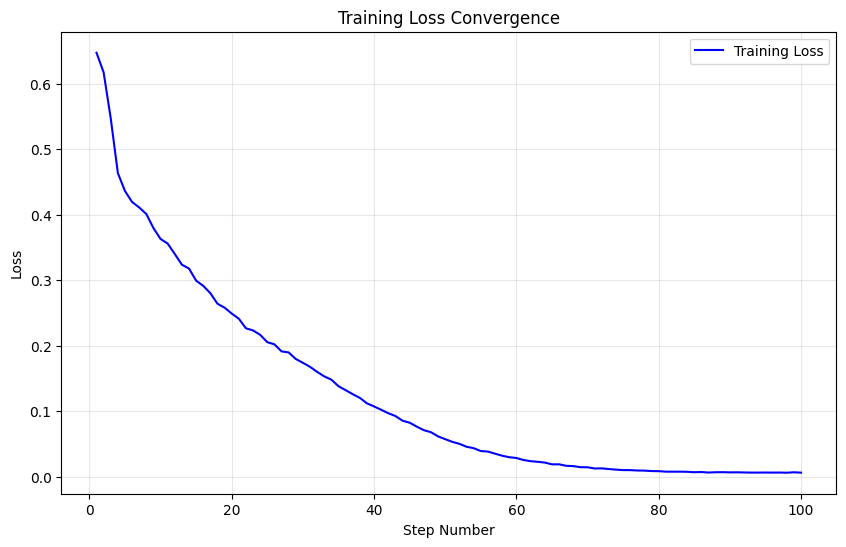

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
train_df = pd.read_csv('./tmp/train_output/step_wise_training_metrics.csv')
# val_df = pd.read_csv('./tmp/train_output/validation_metrics.csv')


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_df['step_number'], train_df['training_loss'], label='Training Loss', color='blue')
# plt.plot(val_df['step_number'], val_df['validation_loss'], label='Validation Loss', color='red')


plt.xlabel('Step Number')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Model evaluation and baseline comparison  

The purpose of the evaluation process is to assess trained-model performance against benchmarks or custom dataset. The evaluation process typically involves steps to create evaluation recipe pointing to the trained model, specify evaluation datasets and metrics, submit a separate training job for the evaluation, and evaluate against standard benchmarks or custom data. The evaluation process will output performance metrics stored in your Amazon S3 bucket.

We use evaluation with custom metrics that signify tool selection and usage of a base vs fine-tuned model.

We measure the following metrics:

* tool_precision
* tool_recall
* tool_f1
* parameter_accuracy
* schema_validation
* sequence_accuracy
* overall_score 
{
    "tools": 0.3,
    "params": 0.3,
    "sequence": 0.4
}

![alt text](imgs/eval_gif.gif)

### Base Model Eval

#### Instance count and Instance Type

Defines the Instance type and count to use for Evaluation 

In [60]:
instance_type = "ml.p5.48xlarge" # Override the instance type if you want to get a different container version
instance_count = 1

instance_type

'ml.p5.48xlarge'

#### Image URI for Evaluation

This specifies the pre-built container for Evaluation, which is different from the SFT container.


In [61]:
image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest"
image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest'

#### Lambda function for Evaluation

Build and deploy lambda, use arn in recipe


In [ ]:
%%writefile lambda_eval_function_sft.py


In [ ]:
from utils.lambda_deployer import create_lambda_function
from utils.lambda_role_helper import get_or_create_lambda_role
import time

# Deploy your Lambda function
role_arn = get_or_create_lambda_role(
    role_name="reward_function_lambda_role",
    managed_policies=[
        "arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        "arn:aws:iam::aws:policy/AmazonBedrockFullAccess"
    ]
)
time.sleep(15)

arn = create_lambda_function(
    lambda_script_path="lambda_eval_function_sft.py",
    function_name="lambda_eval_function_sft",
    role_arn=role_arn,
    skip_if_exists=True
)

print(f"Lambda ARN: {arn}")

In [ ]:
from utils import add_lambda_invoke_permission_to_customization_role

add_lambda_invoke_permission_to_customization_role(
    role_arn=role,
    lambda_function_arn=arn
)

#### Configuring the Model and Recipe

This specifies which model evaluation to use.


In [ ]:
model_id = "nova-lite-2/prod"
recipe = "evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_bring_your_own_dataset_eval.yaml" # https://github.com/aws/sagemaker-hyperpod-recipes/blob/main/recipes_collection/recipes/evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_bring_your_own_dataset_eval.yaml

In [ ]:
recipe_overrides = {
    "inference": {
        "max_new_tokens": 2048,
        "top_logprobs": 10
    },
    "processor":{
        "lambda_type": "custom_metrics",
        "lambda_arn": arn,
        "preprocessing": {
            "enabled": True
        }
    }
}


#### PyTorch Estimator

This creates a PyTorch estimator with the configuration to run the evaluation job.


In [ ]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
eval_job_name = f"eval-{model_id.split('/')[0].replace('.', '-')}-base-eval"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{eval_job_name}"
else:
    output_path = f"s3://{bucket_name}/{eval_job_name}"
    
eval_estimator = PyTorch(
    output_path=output_path,
    base_job_name=eval_job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri,
    recipe_overrides=recipe_overrides
)

INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.


#### Configuring the Data Channel

In [ ]:
from sagemaker.inputs import TrainingInput

eval_input = TrainingInput(
    s3_data=test_dataset_s3_path_sft,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
)

#### Starting the Evaluation (Training) Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [ ]:
# starting the train job with our uploaded datasets as input
eval_estimator.fit(inputs={"train": eval_input}, wait=False)

In [ ]:
eval_job_name = eval_estimator.latest_training_job.name
print('Evaluation Job Name:  {}'.format(eval_job_name))

In [ ]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, eval_job_name, "us-east-1")))



#### Viewing the Evaluation Artifacts 
Downloading the artifact from Evaluation. 


In [ ]:
import boto3
import os

# Get the model S3 URI from the estimator
model_s3_uri = eval_estimator.model_data
output_s3_uri = "/".join(model_s3_uri.split("/")[:-1]) + "/output.tar.gz"

# Parse the S3 URI
s3_parts = output_s3_uri.replace("s3://", "").split("/")
bucket = s3_parts[0]
key = "/".join(s3_parts[1:])

# Create the output directory
os.makedirs("./tmp/eval_output/base_model/", exist_ok=True)

# Download the file
s3_client = boto3.client('s3')
s3_client.download_file(bucket, key, "./tmp/eval_output/base_model/output.tar.gz")

print(f"Downloaded to ./tmp/eval_output/base_model/output.tar.gz")


Downloaded to ./tmp/eval_output/base_model/output.tar.gz


In [59]:
import tarfile
import os
tarfile.open('tmp/eval_output/base_model/output.tar.gz', 'r:gz').extractall('tmp/eval_output/base_model/output_folder')

/var/folders/f4/8kypcdxn5tlb1858pvxr4b780000gr/T/ipykernel_84004/2804565236.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open('tmp/eval_output/base_model/output.tar.gz', 'r:gz').extractall('tmp/eval_output/base_model/output_folder')


In [60]:
results_path = "tmp/eval_output/base_model/output_folder/" + "tool-use-eval" +"/eval_results"

#### Visualize results


/var/folders/f4/8kypcdxn5tlb1858pvxr4b780000gr/T/ipykernel_84004/2392685696.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


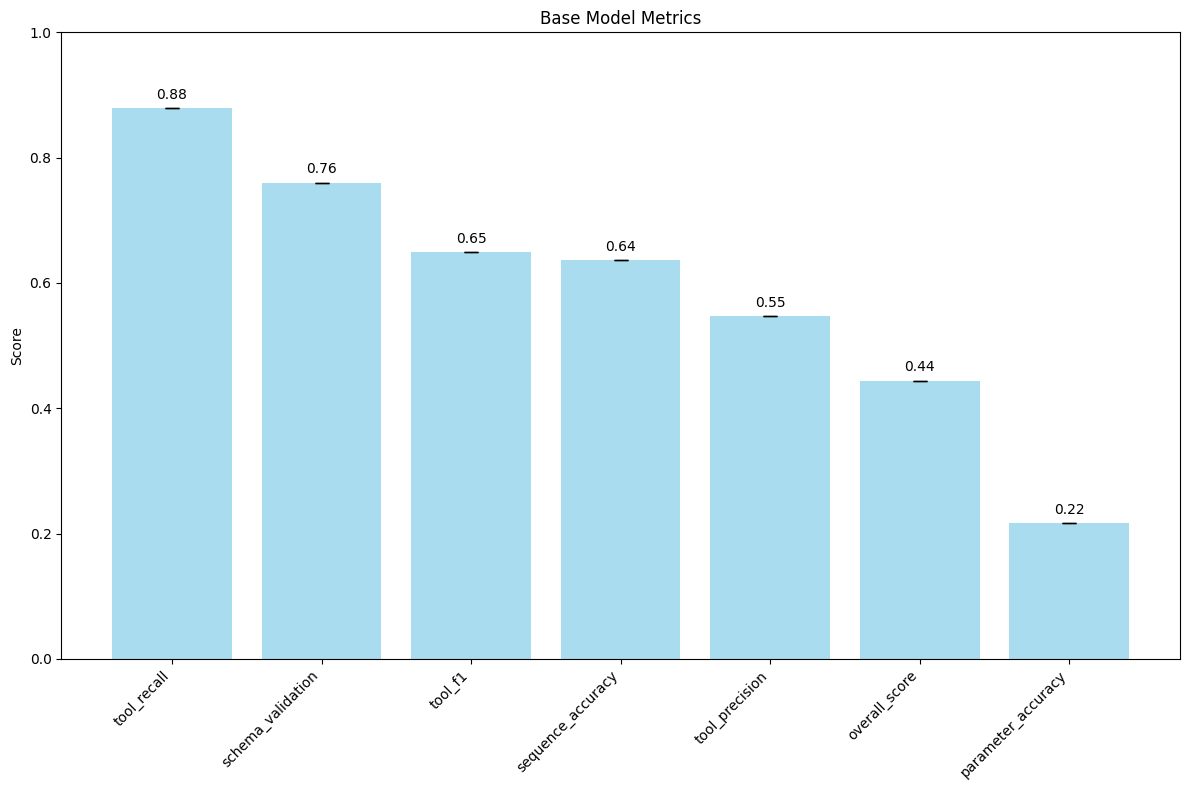

In [61]:
from utils.plots import plot_metrics, find_json_files

evaluation_results_path = find_json_files(results_path)[0]

with open(evaluation_results_path, "r") as f:
    data = json.load(f)

eval_dict = data["results"]['custom|gen_qa_gen_qa|0']

metrics_to_plot = ["tool_precision", "tool_recall", "tool_f1", "parameter_accuracy", "schema_validation", "sequence_accuracy", "overall_score"]

base_model_metrics = {k:eval_dict[k] for k in eval_dict if k in metrics_to_plot}

fig = plot_metrics(base_model_metrics, title="Base Model Metrics")

# Display the plot in the notebook
fig.show()

### Fine-Tuned Model Eval

#### Instance count and Instance Type

Defines the Instance type and count to use for Evaluation 

In [43]:
instance_type = "ml.p5.48xlarge" # Override the instance type if you want to get a different container version
instance_count = 1

instance_type

'ml.p5.48xlarge'

#### Image URI for Evaluation

This specifies the pre-built container for Evaluation, which is different from the SFT container.


In [44]:
image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest"
image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest'

#### Configuring the Model and Recipe

This specifies which model evaluation to use.


In [ ]:
model_id = "nova-lite-2/prod"
recipe = "evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_bring_your_own_dataset_eval.yaml" # https://github.com/aws/sagemaker-hyperpod-recipes/blob/main/recipes_collection/recipes/evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_bring_your_own_dataset_eval.yaml

In [ ]:
recipe_overrides = {
    "run": {
        "model_name_or_path": checkpoint_S3_uri
    },
    "inference": {
        "max_new_tokens": 2048,
        "top_logprobs": 10
    },
    "processor":{
        "lambda_type": "custom_metrics",
        "lambda_arn": arn,
        "preprocessing": {
            "enabled": True
        }
    }
}

#### PyTorch Estimator

This creates a PyTorch estimator with the configuration to run the evaluation job.


In [ ]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
eval_job_name = f"eval-{model_id.split('/')[0].replace('.', '-')}-peft-sft-eval"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{eval_job_name}"
else:
    output_path = f"s3://{bucket_name}/{eval_job_name}"
    
eval_estimator = PyTorch(
    output_path=output_path,
    base_job_name=eval_job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri,
    recipe_overrides=recipe_overrides
)

INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.


#### Configuring the Data Channel

In [ ]:
from sagemaker.inputs import TrainingInput

eval_input = TrainingInput(
    s3_data=test_dataset_s3_path_sft,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
)

#### Starting the Evaluation (Training) Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [ ]:
# starting the train job with our uploaded datasets as input
eval_estimator.fit(inputs={"train": eval_input}, wait=False)

In [ ]:
eval_job_name = eval_estimator.latest_training_job.name
print('Evaluation Job Name:  {}'.format(eval_job_name))

In [ ]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, eval_job_name, "us-east-1")))



#### ^^ _This will take 20-30 mins in evaluation_

#### Viewing the Evaluation Artifacts 
Downloading the artifact from Evaluation. 


In [ ]:
import boto3
import os

# Get the model S3 URI from the estimator
model_s3_uri = eval_estimator.model_data
output_s3_uri = "/".join(model_s3_uri.split("/")[:-1]) + "/output.tar.gz"

# Parse the S3 URI
s3_parts = output_s3_uri.replace("s3://", "").split("/")
bucket = s3_parts[0]
key = "/".join(s3_parts[1:])

# Create the output directory
os.makedirs("./tmp/eval_output/fine_tuned_model/", exist_ok=True)

# Download the file
s3_client = boto3.client('s3')
s3_client.download_file(bucket, key, "./tmp/eval_output/fine_tuned_model/output.tar.gz")

print(f"Downloaded to ./tmp/eval_output/fine_tuned_model/output.tar.gz")


Downloaded to ./tmp/eval_output/fine_tuned_model/output.tar.gz


In [54]:
import tarfile
import os
tarfile.open('tmp/eval_output/fine_tuned_model/output.tar.gz', 'r:gz').extractall('tmp/eval_output/fine_tuned_model/output_folder')

/var/folders/f4/8kypcdxn5tlb1858pvxr4b780000gr/T/ipykernel_84004/2179667965.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open('tmp/eval_output/fine_tuned_model/output.tar.gz', 'r:gz').extractall('tmp/eval_output/fine_tuned_model/output_folder')


In [55]:
results_path = "tmp/eval_output/fine_tuned_model/output_folder/" + "tool-use-eval" +"/eval_results"

#### Visualize results


/var/folders/f4/8kypcdxn5tlb1858pvxr4b780000gr/T/ipykernel_84004/2554045353.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


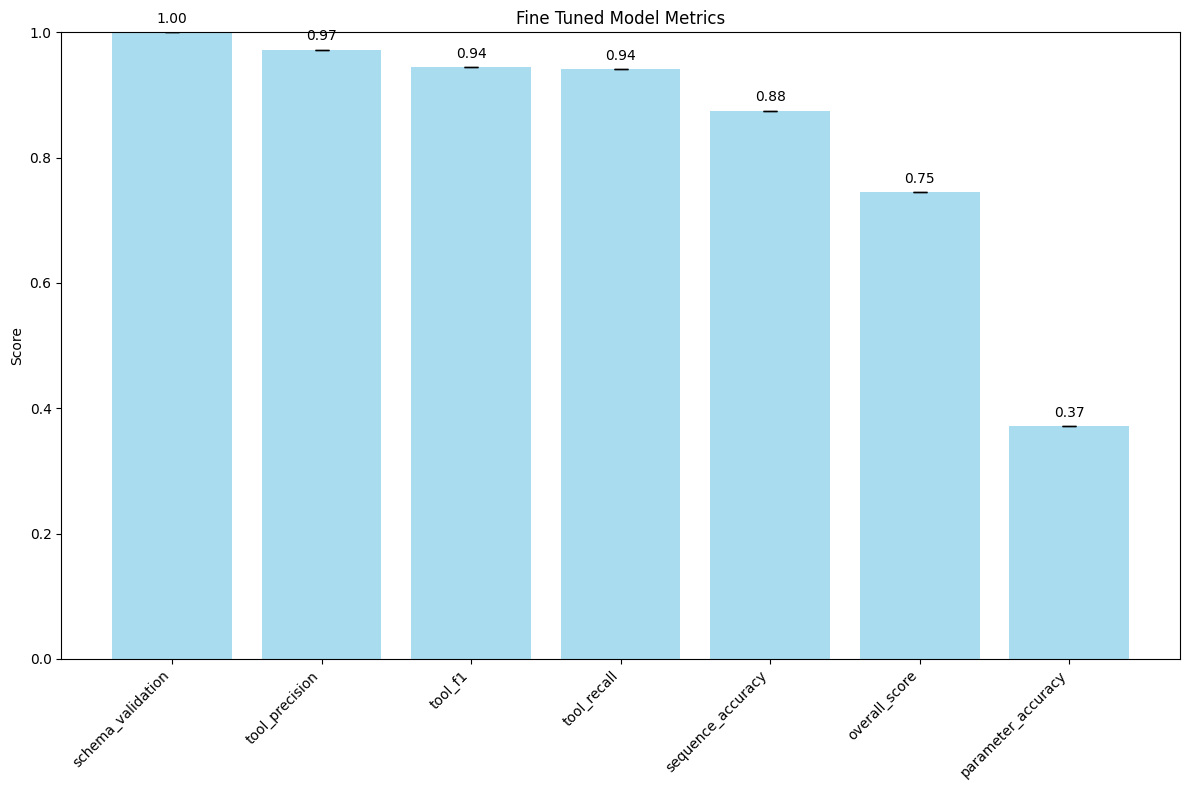

In [56]:
from utils.plots import plot_metrics, find_json_files

evaluation_results_path = find_json_files(results_path)[0]

with open(evaluation_results_path, "r") as f:
    data = json.load(f)

eval_dict = data["results"]['custom|gen_qa_gen_qa|0']

metrics_to_plot = ["tool_precision", "tool_recall", "tool_f1", "parameter_accuracy", "schema_validation", "sequence_accuracy", "overall_score"]

fine_tuned_model_metrics = {k:eval_dict[k] for k in eval_dict if k in metrics_to_plot}

fig = plot_metrics(fine_tuned_model_metrics, title="Fine Tuned Model Metrics")

# Display the plot in the notebook
fig.show()

### Compare

In [ ]:
base_model_metrics['model_conf'] = 'Base Nova 2.0'
fine_tuned_model_metrics['model_conf'] = 'Fine-Tuned Nova 2.0'

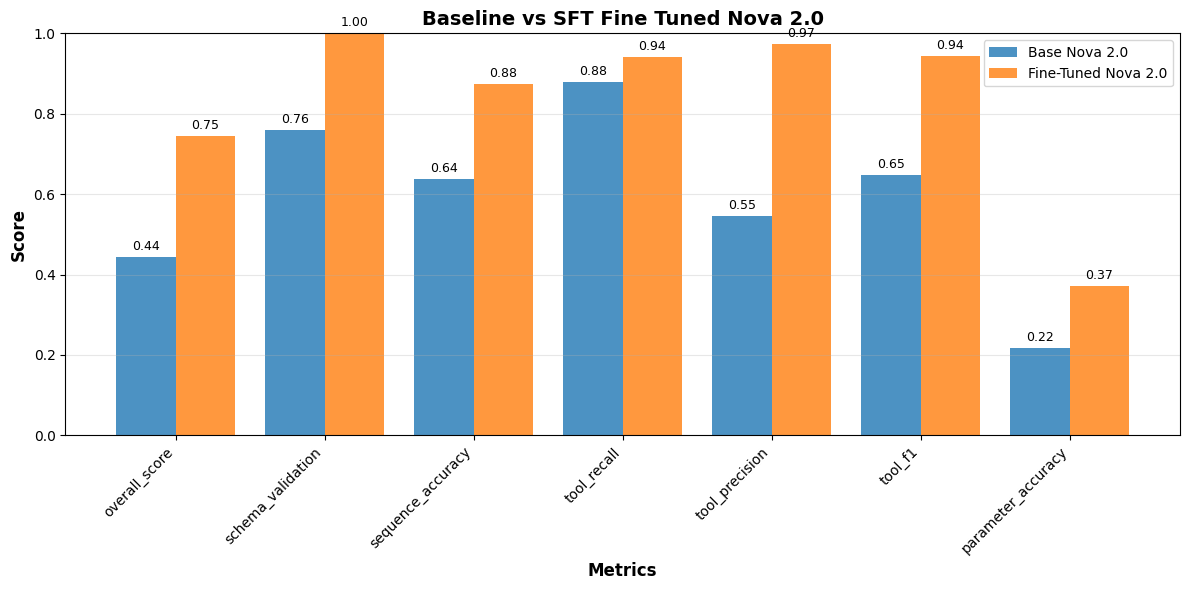

In [ ]:
from utils.plots import plot_grouped_bar_chart
import pandas as pd

results_df = pd.DataFrame([base_model_metrics, fine_tuned_model_metrics])

_ = plot_grouped_bar_chart(
    df=results_df,
    title='Baseline vs SFT Fine Tuned Nova 2.0'
)

In [6]:
%store checkpoint_S3_uri
%store results_df

Stored 'checkpoint_S3_uri' (str)
Stored 'results_df' (DataFrame)
